In [1]:
# imports

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, Model
import random
import time
import matplotlib.pyplot as plt
#import math

# fun fact, I have this number tattooed on my arm so its something I always set my seed
# to when testing/training/debugging code
random.seed(137)

data = keras.datasets.fashion_mnist.load_data()

# As an aside, whenever I do coding assignments, I like to leave a lot of comments showing my thought process
# This is to show 1.) I actually understand the code, 2.) it helps me remember the logical steps I took
# when making the code so I can debug it later, and 3.) I've been staring at this for hours and my wife is busy
# so I can't talk to her about this (Shes a physical therapist and doesn't understand it anyways but I helped her study 
# through PT school at GSU so she helps me by letting me teach/explain to her what I am doing)

In [13]:
# testing size parameters

epochs = 50
batch_size = 50  

In [14]:
# data preprocessing

# splittinf data into train and test
train_data = data[0][0]
y_train = data[0][1]
test_data = data[1][0]
y_test = data[1][1]

# normalizing the data
train_data = train_data.astype('float32')/255
test_data = test_data.astype('float32')/255

# reshaping the data from a 28x28 image into a vector
train_data = train_data.reshape( -1,784)
test_data = test_data.reshape(-1, 784)

In [15]:
# encoder

# defining the initial input of the encoder
input = layers.Input(shape=(784,))

# first layer
layer_1 = layers.Dense(784, activation='relu', input_shape=(784,))(input)

# the layer that generates the mean and log variance
mu = layers.Dense(2, activation=None)(layer_1)
log_var = layers.Dense(2, activation=None)(layer_1)

encoder = Model(input, [mu, log_var])

In [16]:
# decoder

# defining the reparameterization trick ffor z
def z_repara(mu,log_var, size = batch_size):
    
    # making my epislon from a normal distribution
    epsilon = np.random.normal(size=(size, 2))

    # turning the log variance into non-log variance which messed me up during the first
    # couple of trials and took some debugging to determine
    z = mu + tf.exp(log_var / 2) * epsilon
    
    return z

z_input = layers.Input(shape=(2,))

# the output layers of the decoder
layer_2 = layers.Dense(784, activation='relu')(z_input)
output = layers.Dense(784, activation='sigmoid')(layer_2)

decoder = Model(z_input, output)

In [17]:
# optimizer and loss function

# I picked Adam since he's a classic and works really great
# I picked the lr as is based on that's what worked best after multiple trial
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# defining the loss function
def loss(data, mu, log_var):

    z = z_repara(mu, log_var)  
    output = decoder(z) 

    # the cross entropy
    reconstruction_loss = tf.keras.losses.binary_crossentropy(data, output)
    reconstruction_loss = tf.reduce_mean(reconstruction_loss) * 784 

    # the KL loss
    kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
    kl_loss = tf.reduce_mean(kl_loss)

    # total loss determined as the two added together
    total_loss = reconstruction_loss + kl_loss
    
    return total_loss, reconstruction_loss, kl_loss

In [18]:
# Training

# This is something I like to do in my code so I know how long it took
# and I know that notebooks in VS code give you and output but I like being specific
start_time = time.time()
last_time = start_time

# So I can gather the per-epoch info
loss_list = []
time_list =[]

# making an epocH list to help with plotting
epoch_list = [i for i in range(epochs)]

for epoch in range(epochs):
    
    # initializing loss
    total_loss = 0
    
    # determining the number of batches based on the batch size identified earlier
    num_batches = len(train_data) // batch_size  

    # iterating through each batch for the epoch we are in
    for i in range(num_batches):
       
       # splitting the indices into batches
        start = i * batch_size
        end = (i + 1) * batch_size

        # splitting the data into batches
        batch_data = train_data[start:end]
        batch_labels = y_train[start:end]

        # the actual batch data making sure its in the right shape
        batch_data = tf.reshape(batch_data, (-1, 784))  
        
        # this is something that I was not as familiar with and how to read a fair bit of documentation on
        # I think I have it implemented correctly here but that's only after PLENTY of trial and error
        with tf.GradientTape() as t:
            
            mu, log_var = encoder(batch_data)
            loss_value, reconstruction_loss, kl_loss = loss(batch_data, mu, log_var)

        # updating the weights
        gradient = t.gradient(loss_value, encoder.trainable_variables + decoder.trainable_variables)
        optimizer.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))
        total_loss += loss_value

    # post epoch metrics (is that the right word? I don't think so but I don't know a better word)
    loss_list.append(total_loss)

    time_elapsed = int(round(time.time() - last_time))
    time_list.append(time.time() - last_time)
    last_time = time.time()
    
    print(f'Epoch {epoch} - Epoch Run Time: {time_elapsed} Seconds-ish')



Epoch 0 - Epoch Run Time: 27 Seconds-ish
Epoch 1 - Epoch Run Time: 28 Seconds-ish
Epoch 2 - Epoch Run Time: 27 Seconds-ish
Epoch 3 - Epoch Run Time: 28 Seconds-ish
Epoch 4 - Epoch Run Time: 27 Seconds-ish
Epoch 5 - Epoch Run Time: 28 Seconds-ish
Epoch 6 - Epoch Run Time: 27 Seconds-ish
Epoch 7 - Epoch Run Time: 26 Seconds-ish
Epoch 8 - Epoch Run Time: 26 Seconds-ish
Epoch 9 - Epoch Run Time: 26 Seconds-ish
Epoch 10 - Epoch Run Time: 27 Seconds-ish
Epoch 11 - Epoch Run Time: 27 Seconds-ish
Epoch 12 - Epoch Run Time: 27 Seconds-ish
Epoch 13 - Epoch Run Time: 27 Seconds-ish
Epoch 14 - Epoch Run Time: 26 Seconds-ish
Epoch 15 - Epoch Run Time: 27 Seconds-ish
Epoch 16 - Epoch Run Time: 26 Seconds-ish
Epoch 17 - Epoch Run Time: 28 Seconds-ish
Epoch 18 - Epoch Run Time: 26 Seconds-ish
Epoch 19 - Epoch Run Time: 25 Seconds-ish
Epoch 20 - Epoch Run Time: 28 Seconds-ish
Epoch 21 - Epoch Run Time: 31 Seconds-ish
Epoch 22 - Epoch Run Time: 27 Seconds-ish
Epoch 23 - Epoch Run Time: 36 Seconds-ish
Ep

In [19]:
# training metrics

# this just gives a quick run down of the training meta-data like time
# well really only about the time it took
mean_time = round(np.mean(time_list),3)
total_time = round(time.time() - start_time, 1)

print("Mean epoch time: " + str(mean_time) + " seconds")
print("Total run time: " + str(total_time) + " seconds")

Mean epoch time: 26.676 seconds
Total run time: 1333.9 seconds


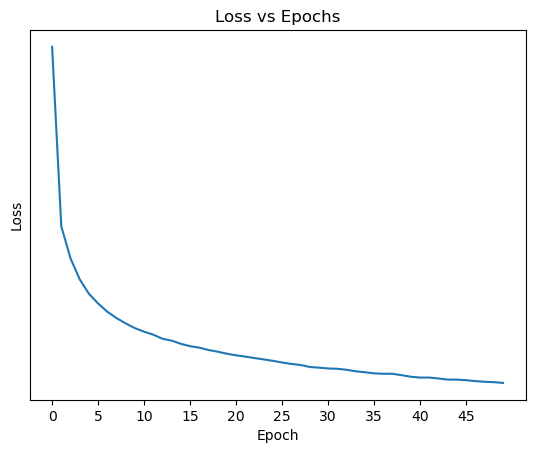

In [24]:
# Epoch vs loss plot

# I did this to make the plot look nice-ish
# Why these values? They make the plot look decent
if epoch < 10:
    step = 1
elif epoch < 50:
    step = 5
elif epoch < 200:
    step = 20
elif epoch < 1000:
    step = 50
else:
    step = 100

plt.plot(epoch_list, loss_list)
plt.yticks([])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(0,epochs,step))
plt.title("Loss vs Epochs")
plt.show()

(5000, 2)


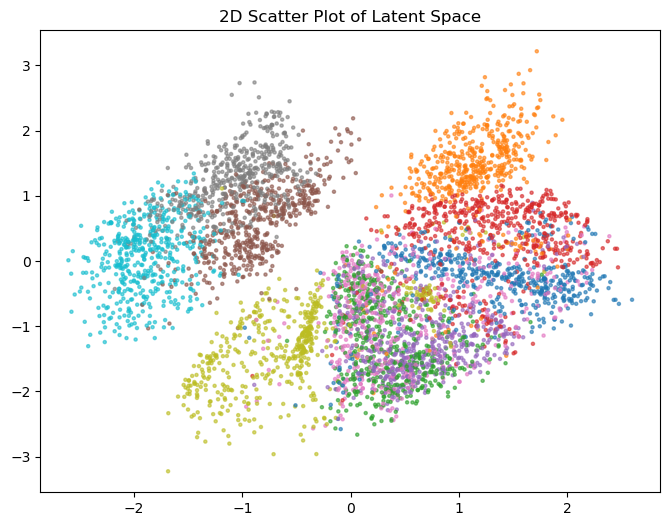

In [25]:
# 2D-scatter plot of z values

# picking a random sample of 5000 indices
# I also did it for 50000 and I thought it was nice
# I almost left it but I wanted to stick to the project description
random_sample = np.random.choice(len(train_data), 5000, replace=False)

data_sample = train_data[random_sample]
data_labels = y_train[random_sample]

mu_sample, log_var_sample = encoder(data_sample)

z_plot_values = z_repara(mu=mu_sample, log_var=log_var_sample, size=5000)

print(z_plot_values.shape)

plt.figure(figsize=(8, 6))
plt.scatter(z_plot_values[:, 0], z_plot_values[:, 1], c=data_labels, cmap="tab10", alpha=0.6, s=5)
plt.title("2D Scatter Plot of Latent Space")
plt.show()

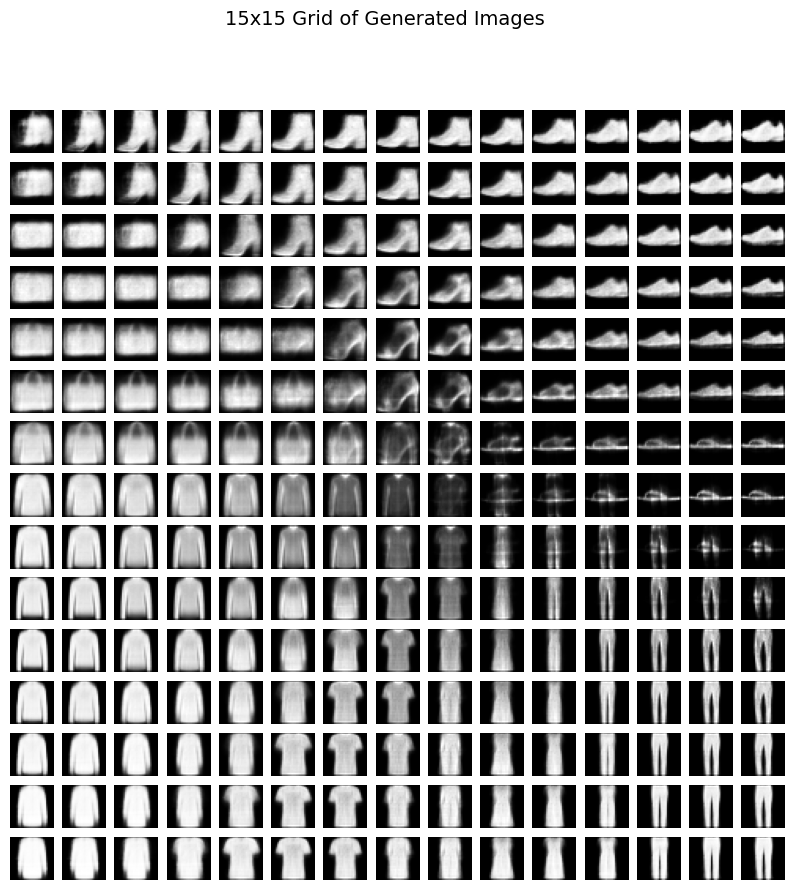

In [22]:
# generated image plot

# I hated making this figure.
grid_size = 15

# making ranges for the two latent variables
# I picked [-2,2] simply because all the other value ranges
# gave a terrrible response
z1_range = np.linspace(-2, 2, grid_size)  
z2_range = np.linspace(-2, 2, grid_size)  

plt.figure(figsize=(10, 10))

# making the combinations of the latent variables
for i, z1 in enumerate(z1_range):
    for j, z2 in enumerate(z2_range):
        z_sample = np.array([[z1, z2]])  
        generated_image = decoder(z_sample).numpy().reshape(28, 28)  

        ax = plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
        ax.imshow(generated_image, cmap="gray")
        ax.axis("off")

# I couldn't think of a better title
plt.suptitle("15x15 Grid of Generated Images", fontsize=14)
plt.show()

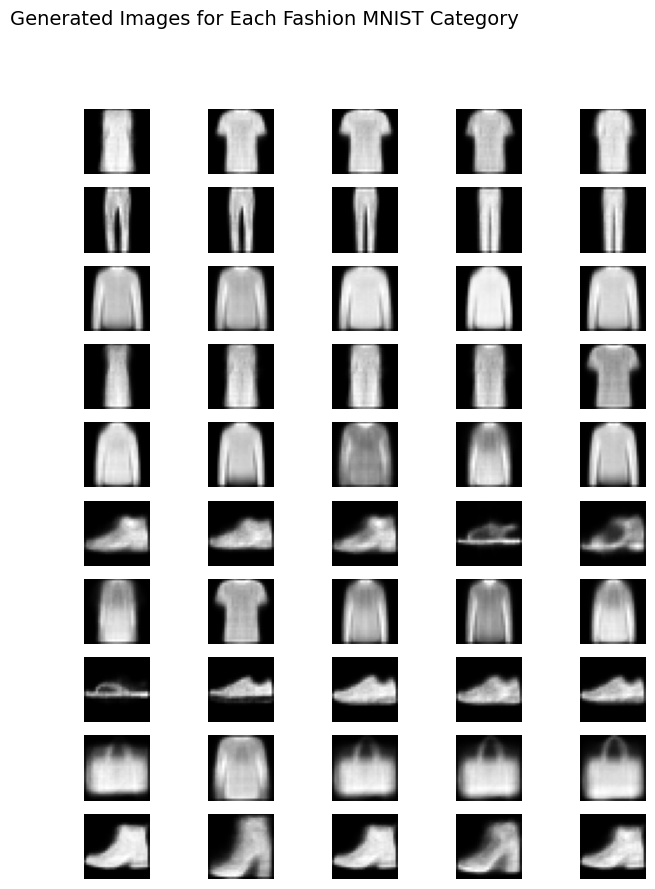

In [23]:
# Class variation plot

# This took me longer than almost any other part of the homework
# I don't know what about this but I banged my head against the wall
# For way too long...
classes = 10
variations = 5  
latent_means = np.zeros((classes, 2))  

# making data to plot in a second
for class_type in range(classes):
    class_indices = np.where(y_train == class_type)[0][:500]  
    class_images = train_data[class_indices]  

    mu, log_var = encoder(class_images)
    z_values = z_repara(mu, log_var, size=500)

    latent_means[class_type] = np.mean(z_values, axis=0)

plt.figure(figsize=(10, 10))

# adding the generated data to the plots
for class_label in range(classes):
    for i in range(variations):
        z_sample = latent_means[class_label] + np.random.normal(scale=0.3, size=(1, 2))
        
        generated_image = decoder(z_sample).numpy().reshape(28, 28)

        ax = plt.subplot(classes, variations, class_label * variations + i + 1)
        ax.imshow(generated_image, cmap="gray")
        ax.axis("off")

plt.suptitle("Generated Images for Each Fashion MNIST Category", fontsize=14)
plt.subplots_adjust(left=0.3)  
plt.show()